In [3]:
!pip install rasterio
!pip install --upgrade pandas

/Users/ethanhsiao/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
     |████████████████████████████████| 21.1 MB 748 kB/s eta 0:00:01     |████████████████████▏           | 13.3 MB 9.9 MB/s eta 0:00:01


In [15]:
import rasterio
import geopandas as gpd
from pathlib import Path
import asf_search as asf
from shapely.geometry import shape
import matplotlib.pyplot as plt
import pandas as pd

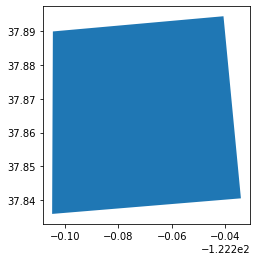

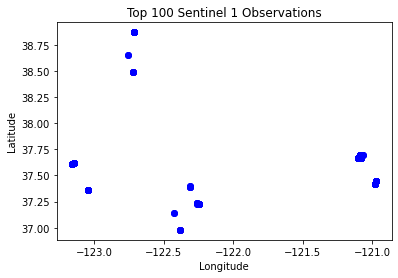

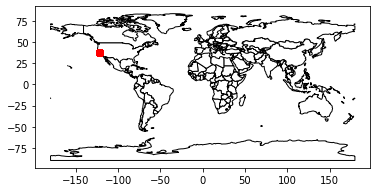

saved files


In [88]:
file = '/Users/ethanhsiao/Documents/ground-swath/data/shape.shp'
transform_data(file)

In [91]:
def transform_data(file):
    place_aoi = gpd.read_file(file)
    place_aoi.geometry.plot()
    place_wkt = place_aoi.geometry.to_wkt()[0]
    opts = {
        'platform': 'S1',#'asf.PLATFORM.SENTINEL1',
        'start': '2019-01-01',
        'end': '2020-02-01',
        'maxResults': 500
        #'processingLevel': asf_search.PRODUCT_TYPE.RTC_HIGH_RES, processingLevel=asf.PRODUCT_TYPE.METADATA,
        #'polarization': asf_search.POLARIZATION.HH_HV,
        #'flightDirection': asf_search.FLIGHT_DIRECTION.ASCENDING
    }
    results = asf_search.geo_search(intersectsWith=place_wkt, **opts)
    S1A, S1B, ascend_ID, descend_ID, latitude, longitude, metadata, raw, grd_hd = [], [], [], [], [], [], [], [], []
    split_platform(S1A, S1B)
    split_flightDirection(ascend_ID, descend_ID)
    add_latitudeLongitude(latitude, longitude)
    plot_latitudeLongitude(ascend_ID, descend_ID, latitude, longitude)
    split_processingLevel(metadata, raw, grd_hd)
    
    #turn data into df
    df = pd.DataFrame(
    {
        'platform':[],
        'flightDirection':[],
        'centerLat':[],
        'centerLon':[],
        'processingLevel':[]
    })
    platformlist, flightlist, latlist, lonlist, processlist = [], [], [], [], []
    for i in range(len(results)):
        platformlist.append(results[i].properties['platform'])
        flightlist.append(results[i].properties['flightDirection'])
        latlist.append(results[i].properties['centerLat'])
        lonlist.append(results[i].properties['centerLon'])
        processlist.append(results[i].properties['processingLevel'])
    df.platform = platformlist
    df.flightDirection = flightlist
    df.centerLat = latlist
    df.centerLon = lonlist
    df.processingLevel = processlist

    #transform df into gdf
    gdf = gpd.GeoDataFrame(df, 
                           geometry=gpd.points_from_xy(df.centerLon, df.centerLat))
    gdf.head()
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black')
    gdf.plot(ax=ax, color='red')
    plt.show()
    
    #save df
    df.to_csv('data/berkeley.csv', index=False)
    gdf.to_file("data/berkeley.geojson", driver='GeoJSON')
    print('saved files')

In [124]:
#splitting by platform S1A/S1B
def split_platform(S1A, S1B):
    for i in range(len(results)):
        #print(results[i].properties['platform'])
        if 'Sentinel-1A' in results[i].properties['platform']:
            S1A.append(i)
        elif 'Sentinel-1B' in results[i].properties['platform']:
            S1B.append(i)

In [125]:
#splitting by ascending/descending flight direction  
def split_flightDirection(ascend_ID, descend_ID):
    for i in range(len(results)):
        if 'ASCENDING' in results[i].properties['flightDirection']:
            ascend_ID.append(i)
        elif 'DESCENDING' in results[i].properties['flightDirection']:
            descend_ID.append(i)

In [126]:
#add latitude/longitude
def add_latitudeLongitude(latitude, longitude):
    for i in range(len(results)):
        if results[i].properties['centerLat']:
            latitude.append(float(results[i].properties['centerLat']))
        if results[i].properties['centerLat']:
            longitude.append(float(results[i].properties['centerLon']))

In [127]:
def plot_latitudeLongitude(ascend_ID, descend_ID, latitude, longitude):
    plt.figure('Observations')
    plt.clf()
    for i in range(len(results)):
        if i in ascend_ID:
            plt.scatter(longitude[i],latitude[i],c='red')
        elif i in descend_ID:
            plt.scatter(longitude[i],latitude[i],c='blue')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Top 100 Sentinel 1 Observations')

In [128]:
#splitting by processingLevel
def split_processingLevel(metadata, raw, grd_hd):
    for i in range(len(results)):
        if 'METADATA_RAW' in results[i].properties['processingLevel']:
            metadata.append(i)
        elif 'GRD_HD' in results[i].properties['processingLevel']:
            grd_hd.append(i)
        else:
            raw.append(i)

In [121]:
results = asf.search(platform=asf.PLATFORM.SENTINEL1, maxResults=100)

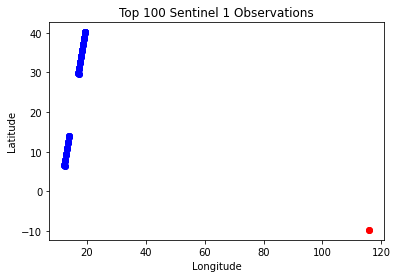

In [122]:
S1A, S1B, ascend_ID, descend_ID, latitude, longitude, metadata, raw, grd_hd = [], [], [], [], [], [], [], [], []
split_platform(S1A, S1B)
split_flightDirection(ascend_ID, descend_ID)
add_latitudeLongitude(latitude, longitude)
plot_latitudeLongitude(ascend_ID, descend_ID, latitude, longitude)
split_processingLevel(metadata, raw, grd_hd)

In [109]:
df = pd.DataFrame(
{
    'platform':[],
    'flightDirection':[],
    'centerLat':[],
    'centerLon':[],
    'processingLevel':[]
})
platformlist = []
flightlist = []
latlist = []
lonlist = []
processlist = []
for i in range(len(results)):
    platformlist.append(results[i].properties['platform'])
    flightlist.append(results[i].properties['flightDirection'])
    latlist.append(results[i].properties['centerLat'])
    lonlist.append(results[i].properties['centerLon'])
    processlist.append(results[i].properties['processingLevel'])
    
df.platform = platformlist
df.flightDirection = flightlist
df.centerLat = latlist
df.centerLon = lonlist
df.processingLevel = processlist

In [110]:
df.head()

,platform,flightDirection,centerLat,centerLon,processingLevel
0,Sentinel-1A,ASCENDING,-9.7033,115.7228,METADATA_RAW
1,Sentinel-1A,ASCENDING,-9.7033,115.7228,RAW
2,Sentinel-1A,DESCENDING,6.6192,12.4177,GRD_HD
3,Sentinel-1A,DESCENDING,6.6192,12.4177,METADATA_GRD_HD
4,Sentinel-1A,DESCENDING,6.4346,12.5419,METADATA_RAW


In [111]:
gdf = gpd.GeoDataFrame(
df, geometry=gpd.points_from_xy(df.centerLon, df.centerLat))

In [112]:
gdf

,platform,flightDirection,centerLat,centerLon,processingLevel,geometry
0,Sentinel-1A,ASCENDING,-9.7033,115.7228,METADATA_RAW,POINT (115.72280 -9.70330)
1,Sentinel-1A,ASCENDING,-9.7033,115.7228,RAW,POINT (115.72280 -9.70330)
2,Sentinel-1A,DESCENDING,6.6192,12.4177,GRD_HD,POINT (12.41770 6.61920)
3,Sentinel-1A,DESCENDING,6.6192,12.4177,METADATA_GRD_HD,POINT (12.41770 6.61920)
4,Sentinel-1A,DESCENDING,6.4346,12.5419,METADATA_RAW,POINT (12.54190 6.43460)
...,...,...,...,...,...,...
95,Sentinel-1A,DESCENDING,40.1252,19.3447,SLC,POINT (19.34470 40.12520)
96,Sentinel-1A,DESCENDING,40.1313,19.3081,GRD_HD,POINT (19.30810 40.13130)
97,Sentinel-1A,DESCENDING,40.1313,19.3081,METADATA_GRD_HD,POINT (19.30810 40.13130)
98,Sentinel-1A,DESCENDING,40.1313,19.308,METADATA_OCN,POINT (19.30800 40.13130)


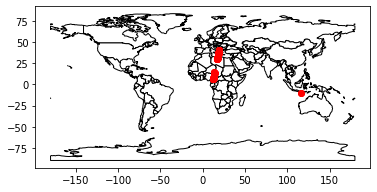

In [113]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

In [114]:
#save df
df.to_csv('data/processed.csv', index=False)

In [115]:
gdf.to_file("data/processed.geojson", driver='GeoJSON')
#gdf.to_file("countries.shp")